### This file is dedicated to forecast the population for 2025, 2026 and 2027 using past data

In [1]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import re

In [2]:
# File paths (update with your actual file paths)
forecast_data_path = '../../data/raw/ABS_population/ABS_population_data.csv'
past_data_path = '../../data/raw/ABS_population/past_population_data_filtered.csv'

# Load the data
forecast_data = pd.read_csv(forecast_data_path)
past_data = pd.read_csv(past_data_path)

In [3]:
# Rename columns in forecast data for consistency
forecast_data = forecast_data.rename(columns={'SA2  code': 'SA2 code', "2021": "population 2021", 
                                              "2026": "population 2026", "2031": "population 2031", 
                                              "2036": "population 2036"})

# Merge the datasets on 'SA2 code'
combined_data = pd.merge(past_data, forecast_data[['SA2 code', 'population 2026', 
                                                   'population 2031', 'population 2036']], on='SA2 code', how='left')

combined_data['population 2022'] = (combined_data['population 2021'] + combined_data['population 2023']) / 2

Now, fit model to predict 2026, 2031, 2036 value and compare with official forecast to find better model

In [4]:
# Function to calculate RMSE and MAE metrics
def calculate_metrics(true_values, predicted_values):
    mse = mean_squared_error(true_values, predicted_values)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(true_values, predicted_values)
    return rmse, mae

# Function to extract numerical part from ARIMA prediction
def extract_numeric(forecast_series):
    return np.array([float(re.search(r'[-+]?\d*\.\d+|\d+', str(f)).group()) for f in forecast_series])

# Store forecasts and metrics for each SA2 code
LR_forecast_results = []
ARIMA_forecast_results = []
arima_rmse_list = []
arima_mae_list = []
linear_rmse_list = []
linear_mae_list = []


In [5]:
# Loop over each SA2 code and apply ARIMA and Linear Regression
for idx, row in combined_data.iterrows():
    sa2_code = row['SA2 code']
    
    # Extract population data for 2001-2023
    population_series = row[['population 2001', 'population 2002', 'population 2003', 
                             'population 2004', 'population 2005', 'population 2006',
                             'population 2007', 'population 2008', 'population 2009',
                             'population 2010', 'population 2011', 'population 2012',
                             'population 2013', 'population 2014', 'population 2015',
                             'population 2016', 'population 2017', 'population 2018',
                             'population 2019', 'population 2020', 'population 2021', 
                             'population 2022', 'population 2023']].T.squeeze()

    # Convert to a datetime index
    population_series.index = pd.date_range(start='2001', periods=len(population_series), freq='YE')

    # ARIMA model
    arima_model = ARIMA(population_series, order=(1, 1, 1))
    arima_model_fit = arima_model.fit()

    # Forecast values for 2025 to 2036
    arima_forecast = arima_model_fit.predict(start='2025', end='2036')
    arima_forecast_values = extract_numeric(arima_forecast)
    
    # Linear Regression model
    years = np.arange(2001, 2024).reshape(-1, 1)
    population = population_series.values.reshape(-1, 1)
    LRmodel = LinearRegression()
    LRmodel.fit(years, population)

    future_years = np.arange(2025, 2037).reshape(-1, 1)
    linear_forecast = LRmodel.predict(future_years).flatten()

    # Save forecasts for 2025, 2026, and 2027 for the CSV
    LR_forecast_results.append([sa2_code, linear_forecast[0], linear_forecast[1], linear_forecast[2]])

    ARIMA_forecast_results.append([sa2_code, arima_forecast_values[0], arima_forecast_values[1], arima_forecast_values[2]])

    # Compare 2026, 2031, and 2036 with official values
    official_values = np.array([row['population 2026'], row['population 2031'], row['population 2036']])

    # Extract ARIMA and Linear predictions for 2026, 2031, and 2036
    arima_predictions = np.array([arima_forecast_values[1], arima_forecast_values[6], arima_forecast_values[11]])
    linear_predictions = np.array([linear_forecast[1], linear_forecast[6], linear_forecast[11]])

    # Calculate ARIMA metrics
    arima_rmse, arima_mae = calculate_metrics(official_values, arima_predictions)
    arima_rmse_list.append(arima_rmse)
    arima_mae_list.append(arima_mae)

    # Calculate Linear Regression metrics
    linear_rmse, linear_mae = calculate_metrics(official_values, linear_predictions)
    linear_rmse_list.append(linear_rmse)
    linear_mae_list.append(linear_mae)



/home/steven/myenv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/steven/myenv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/steven/myenv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/steven/myenv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting aut

In [6]:
# Create DataFrame for forecasts (2025, 2026, 2027)
LR_forecast_df = pd.DataFrame(LR_forecast_results, columns=['area code', 'Linear_2025', 'Linear_2026', 'Linear_2027'])
ARIMA_forecast_df = pd.DataFrame(ARIMA_forecast_results, columns=['area code', 'ARIMA_2025', 'ARIMA_2026', 'ARIMA_2027'])
# Average metrics across all SA2 codes
average_metrics_df = pd.DataFrame({
    'Model': ['ARIMA', 'Linear Regression'],
    'Average RMSE': [np.mean(arima_rmse_list), np.mean(linear_rmse_list)],
    'Average MAE': [np.mean(arima_mae_list), np.mean(linear_mae_list)]
})

print(average_metrics_df)

# Save better forecast to CSV
# LR_forecast_df.to_csv('../../data/raw/ABS_population/population_forecast_2025_2027.csv', index=False)
ARIMA_forecast_df.to_csv('../../data/raw/ABS_population/population_forecast_2025_2027.csv', index=False)

print("Forecast saved to population_forecast_2025_2027.csv")

               Model  Average RMSE  Average MAE
0              ARIMA   1331.144253  1163.243774
1  Linear Regression   2009.865195  1877.576621
Forecast saved to population_forecast_2025_2027.csv


Show an example plot

In [7]:
sa2_code = 201011005.0

# Extract official forecasts for 2026, 2031, and 2036
official_2026 = combined_data.loc[combined_data['SA2 code'] == sa2_code, 'population 2026'].values[0]
official_2031 = combined_data.loc[combined_data['SA2 code'] == sa2_code, 'population 2031'].values[0]
official_2036 = combined_data.loc[combined_data['SA2 code'] == sa2_code, 'population 2036'].values[0]
official_values = np.array([official_2026, official_2031, official_2036])


# Select a specific population time series for a given area (e.g., by SA2 code)
population_series = combined_data.loc[combined_data['SA2 code'] == sa2_code, 
                                      ['population 2001', 'population 2002', 'population 2003', 
                                       'population 2004', 'population 2005', 'population 2006',
                                       'population 2007', 'population 2008', 'population 2009',
                                       'population 2010', 'population 2011', 'population 2012',
                                       'population 2013', 'population 2014', 'population 2015',
                                       'population 2016', 'population 2017', 'population 2018',
                                       'population 2019', 'population 2020', 'population 2021', 
                                       'population 2022', 'population 2023']].T.squeeze()

# Convert the index to a datetime index with yearly frequency
population_series.index = pd.date_range(start='2001', periods=len(population_series), freq='YE')



2025-12-31    7348.711900
2026-12-31    7360.345192
2027-12-31    7371.232666
2028-12-31    7381.422138
2029-12-31    7390.958355
2030-12-31    7399.883200
2031-12-31    7408.235867
2032-12-31    7416.053039
2033-12-31    7423.369047
2034-12-31    7430.216021
2035-12-31    7436.624031
2036-12-31    7442.621220
Freq: YE-DEC, Name: predicted_mean, dtype: float64


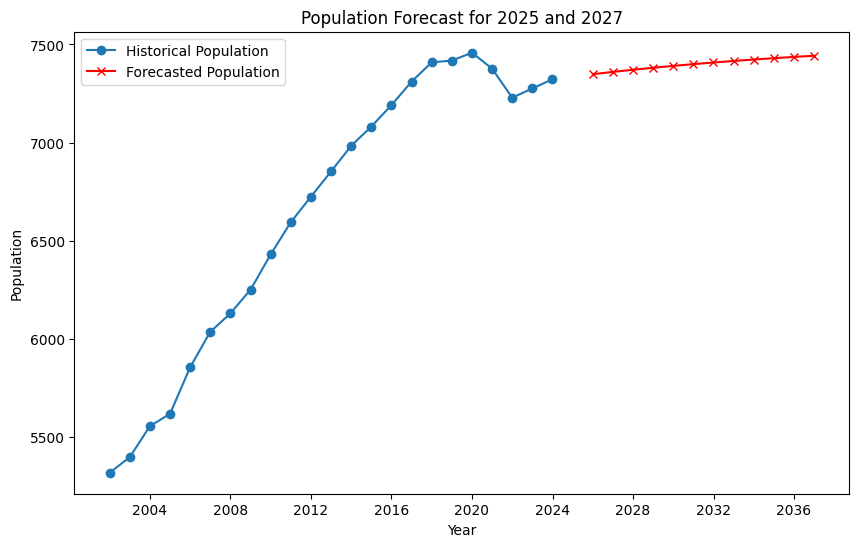

In [8]:
# Fit ARIMA model
arima_model = ARIMA(population_series, order=(1, 1, 1))
arima_model_fit = arima_model.fit()

# Forecast population for 2025 and 2027
forecast = arima_model_fit.predict(start='2025', end='2036')

print(forecast)
# Plot the historical data and forecast
plt.figure(figsize=(10, 6))
plt.plot(population_series, label='Historical Population', marker='o')
plt.plot(forecast, label='Forecasted Population', marker='x', color='red')

# Add labels and title
plt.title('Population Forecast for 2025 and 2027')
plt.xlabel('Year')
plt.ylabel('Population')
plt.legend()

# Show the plot
plt.show()


[[7975.08992095]
 [8077.40118577]
 [8179.71245059]
 [8282.02371542]
 [8384.33498024]
 [8486.64624506]
 [8588.95750988]
 [8691.2687747 ]
 [8793.58003953]
 [8895.89130435]
 [8998.20256917]
 [9100.51383399]]


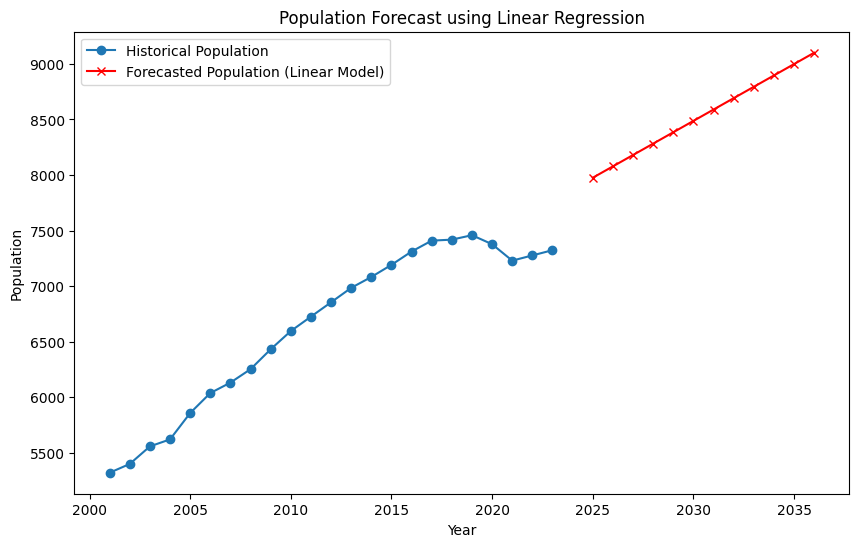

In [9]:
# linear regression
years = np.arange(2001, 2024).reshape(-1, 1)  # Independent variable (years from 2001 to 2023)
population = population_series.values.reshape(-1, 1)  # Dependent variable (population values)

# Initialize and fit the linear regression model
LRmodel = LinearRegression()
LRmodel.fit(years, population)

# Predict population for 2025 to 2036
future_years = np.arange(2025, 2037).reshape(-1, 1)
forecast = LRmodel.predict(future_years)

print(forecast)
# Plot the historical data and forecast
plt.figure(figsize=(10, 6))
plt.plot(years, population, label='Historical Population', marker='o')
plt.plot(future_years, forecast, label='Forecasted Population (Linear Model)', marker='x', color='red')

# Add labels and title
plt.title('Population Forecast using Linear Regression')
plt.xlabel('Year')
plt.ylabel('Population')
plt.legend()

# Show the plot
plt.show()
